# Build the LSLGA parent sample

The purpose of this notebook is to build the parent sample for the NASA Legacy Surveys Galaxy Atlas (LSLGA).

Our starting catalog is the file *ned-d25min10.txt*, which contains 8,131,378 objects and is the (semi-raw) output of querying the NED database (on 2018 March 26) for all objects with a D(25) isophotal diameter (in any band) greater than 10 arcsec, with no requirements on redshift or object type.  

Next, we run
```bash
% time python parse-ned-sample
```
to restrict the sample to:
  1. "galaxies" (object type "G", "GGroup", "GPair", "GTrpl", or "PofG"), leaving 4,755,411 objects;
  2. objects with an approximate magnitude and angular diameter (from NED, in any band), leaving 4,385,048 objects;
  3. objects in the Legacy Survey / DESI footprint, leaving 3,512,936 objects.

Specifically, we parse and merge various apparent magnitude estimates (from SDSS/r, 2MASS/Ks, RC3/B, and APM/bJ, in that order of priority), and angular diameters (D25), minor-to-major axis ratios (b/a), and position angles (pa) (from SDSS, 2MASS, RC3, and ESO, in that order of priority).

The final output file--and our starting parent sample of objects--is called *large-galaxies-parent.fits*.

**ToDo**: 

1. Build unWISE mosaics.
2. Filter and sort the sample; try to remove junk.
3. Include additional metadata in the webpage.

### Imports and paths

In [211]:
import os
import shutil, time, warnings
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma
import pandas as pd

In [212]:
import fitsio
from astropy.table import Table, Column, vstack

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

In [214]:
sns.set(style='ticks', font_scale=1.5, palette='Set2')
%matplotlib inline

In [215]:
LSLGAdir = os.getenv('LSLGA_DIR')
parentfile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-parent.fits')
samplefile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-dr6-dr7.fits')

### Read the parent sample.

In [216]:
def read_parent():
    parent = Table(fitsio.read(parentfile, ext=1)).to_pandas() # , rows=np.arange(100))
    print('Read {} objects from {}'.format(len(parent), parentfile))
    return parent

In [217]:
parent = read_parent()
parent

Read 3512936 objects from /Users/kevinnapier/data/LSLGA/sample/large-galaxies-parent.fits


,galaxy,objtype,ra,dec,z,zqual,morph,mag,mag_err,mag_band,d25,d25_band,ba25,ba25_band,pa,pa_band,notes
0,b'SDSS J025901.06+005350.3',b'G',44.754542,0.897278,0.134638,b'N/A',b'N/A',17.450541,NaN,b'r',0.377500,b'r',0.532,b'r',134.0,b'r',b'N/A'
1,b'SDSS J025952.35+005333.5',b'G',44.968125,0.892667,NaN,b'N/A',b'N/A',18.598565,NaN,b'r',0.178000,b'r',0.466,b'r',123.0,b'r',b'N/A'
2,b'SDSS J025825.68+004014.1',b'G',44.607000,0.670583,NaN,b'N/A',b'N/A',21.229535,NaN,b'r',0.322833,b'r',0.072,b'r',39.0,b'r',b'N/A'
3,b'SDSS J025940.84+001307.6',b'G',44.920208,0.218778,NaN,b'N/A',b'N/A',19.258178,NaN,b'r',0.176667,b'r',0.413,b'r',15.0,b'r',b'N/A'
4,b'SDSS J025831.82+002854.7',b'G',44.632583,0.481889,0.193223,b'N/A',b'N/A',17.678623,0.149580,b'r',0.211500,b'r',0.759,b'r',40.0,b'r',b'N/A'
5,b'SDSS J030122.20+002944.1',b'G',45.342500,0.495583,NaN,b'N/A',b'N/A',19.379473,0.184332,b'r',0.180167,b'r',0.322,b'r',176.0,b'r',b'N/A'
6,b'SDSS J030022.98+010354.8',b'G',45.095792,1.065250,0.165026,b'SPEC',b'N/A',18.496580,0.149465,b'r',0.200500,b'r',0.615,b'r',167.0,b'r',b'N/A'
7,b'SDSS J030014.73+003044.9',b'G',45.061417,0.512472,0.162356,b'SPEC',b'N/A',18.519279,0.184103,b'r',0.199500,b'r',0.563,b'r',52.0,b'r',b'N/A'
8,b'SDSS J025940.77+001921.4',b'G',44.919875,0.322611,NaN,b'N/A',b'N/A',18.369531,0.184011,b'r',0.179500,b'r',0.577,b'r',10.0,b'r',b'N/A'
9,b'SDSS J025910.53+004416.3',b'G',44.793875,0.737917,0.190430,b'SPEC',b'N/A',17.896499,0.149229,b'r',0.180833,b'r',0.929,b'r',31.0,b'r',b'N/A'


### Generate some QA.

In [218]:
icrap = np.logical_or(
    np.logical_and(parent['galaxy'].astype('str').str.contains('SDSS'), parent['z'].isnull() ), 
    np.logical_and(parent['galaxy'].astype('str').str.contains('2MASX'), parent['z'].isnull() ) )

In [219]:
crap = parent[icrap]
print(len(crap))
crap

2638488


,galaxy,objtype,ra,dec,z,zqual,morph,mag,mag_err,mag_band,d25,d25_band,ba25,ba25_band,pa,pa_band,notes
1,b'SDSS J025952.35+005333.5',b'G',44.968125,0.892667,NaN,b'N/A',b'N/A',18.598565,NaN,b'r',0.178000,b'r',0.466,b'r',123.0,b'r',b'N/A'
2,b'SDSS J025825.68+004014.1',b'G',44.607000,0.670583,NaN,b'N/A',b'N/A',21.229535,NaN,b'r',0.322833,b'r',0.072,b'r',39.0,b'r',b'N/A'
3,b'SDSS J025940.84+001307.6',b'G',44.920208,0.218778,NaN,b'N/A',b'N/A',19.258178,NaN,b'r',0.176667,b'r',0.413,b'r',15.0,b'r',b'N/A'
5,b'SDSS J030122.20+002944.1',b'G',45.342500,0.495583,NaN,b'N/A',b'N/A',19.379473,0.184332,b'r',0.180167,b'r',0.322,b'r',176.0,b'r',b'N/A'
8,b'SDSS J025940.77+001921.4',b'G',44.919875,0.322611,NaN,b'N/A',b'N/A',18.369531,0.184011,b'r',0.179500,b'r',0.577,b'r',10.0,b'r',b'N/A'
11,b'SDSS J025800.50+002917.5',b'G',44.502125,0.488222,NaN,b'N/A',b'N/A',22.590634,NaN,b'r',0.587667,b'r',0.008,b'r',45.0,b'r',b'N/A'
12,b'SDSS J025908.40+002325.9',b'G',44.785042,0.390528,NaN,b'N/A',b'N/A',18.261819,NaN,b'r',0.181167,b'r',0.737,b'r',34.0,b'r',b'N/A'
14,b'SDSS J030022.31+010007.5',b'G',45.093000,1.002083,NaN,b'N/A',b'N/A',20.262888,NaN,b'r',0.183333,b'r',0.155,b'r',31.0,b'r',b'N/A'
15,b'SDSS J025842.46+001640.2',b'G',44.676917,0.277861,NaN,b'N/A',b'N/A',18.481707,NaN,b'r',0.185500,b'r',0.617,b'r',166.0,b'r',b'N/A'
16,b'SDSS J030118.40+004606.5',b'G',45.326667,0.768472,NaN,b'N/A',b'N/A',22.093415,NaN,b'r',0.192500,b'r',0.134,b'r',138.0,b'r',b'N/A'


In [220]:
clean = parent[~icrap]
print(len(clean))
clean

874448


,galaxy,objtype,ra,dec,z,zqual,morph,mag,mag_err,mag_band,d25,d25_band,ba25,ba25_band,pa,pa_band,notes
0,b'SDSS J025901.06+005350.3',b'G',44.754542,0.897278,0.134638,b'N/A',b'N/A',17.450541,NaN,b'r',0.377500,b'r',0.532,b'r',134.0,b'r',b'N/A'
4,b'SDSS J025831.82+002854.7',b'G',44.632583,0.481889,0.193223,b'N/A',b'N/A',17.678623,0.149580,b'r',0.211500,b'r',0.759,b'r',40.0,b'r',b'N/A'
6,b'SDSS J030022.98+010354.8',b'G',45.095792,1.065250,0.165026,b'SPEC',b'N/A',18.496580,0.149465,b'r',0.200500,b'r',0.615,b'r',167.0,b'r',b'N/A'
7,b'SDSS J030014.73+003044.9',b'G',45.061417,0.512472,0.162356,b'SPEC',b'N/A',18.519279,0.184103,b'r',0.199500,b'r',0.563,b'r',52.0,b'r',b'N/A'
9,b'SDSS J025910.53+004416.3',b'G',44.793875,0.737917,0.190430,b'SPEC',b'N/A',17.896499,0.149229,b'r',0.180833,b'r',0.929,b'r',31.0,b'r',b'N/A'
10,b'2MASX J02593256+0013543',b'G',44.885583,0.231778,0.193277,b'N/A',b'N/A',14.381162,0.120243,b'Ks',0.303333,b'Ks',0.720,b'Ks',140.0,b'Ks',b'N/A'
13,b'SDSS J030133.76+005045.4',b'G',45.390667,0.845972,0.133466,b'SPEC',b'N/A',18.163834,0.149626,b'r',0.196167,b'r',0.503,b'r',12.0,b'r',b'N/A'
18,b'SDSS J030056.78+005344.2',b'G',45.236583,0.895667,0.107495,b'SPEC',b'N/A',19.310774,NaN,b'r',0.188833,b'r',0.319,b'r',169.0,b'r',b'N/A'
23,b'SDSS J025907.63+004548.4',b'G',44.781792,0.763472,0.134386,b'N/A',b'N/A',17.433532,0.126933,b'r',0.252667,b'r',0.746,b'r',43.0,b'r',b'N/A'
24,b'SDSS J025952.36+005755.5',b'G',44.968250,0.965444,0.106898,b'SPEC',b'N/A',18.330283,0.149455,b'r',0.175167,b'r',0.926,b'r',24.0,b'r',b'N/A'


In [221]:
def qa_radec(png=None):
    fig, ax = plt.subplots()
    ax.scatter(clean['ra'], clean['dec'], s=1)
    if png:
        fig.savefig(png)

In [222]:
def qa_d25():
    fig, ax = plt.subplots()
    _ = ax.hist(crap['d25'], bins=100, range=(0, 2))
    _ = ax.hist(clean['d25'], bins=100, range=(0, 2), alpha=0.75)

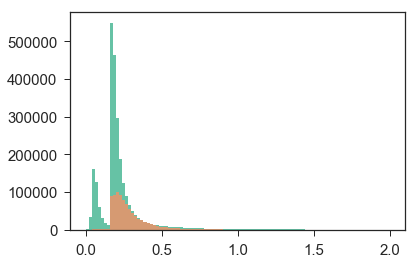

In [223]:
qa_d25()

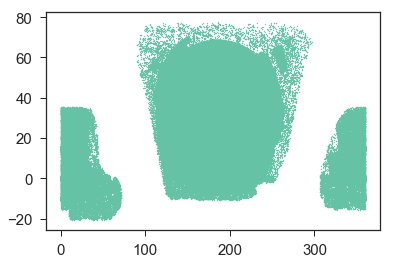

In [224]:
qa_radec()

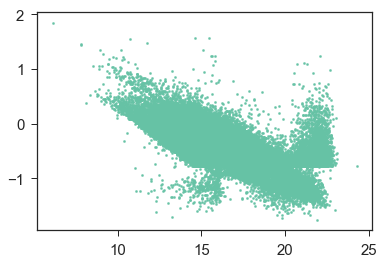

In [225]:
plt.scatter(clean['mag'], np.log10(clean['d25']), s=5)

1) The magnitudes are a mix of r, Ks, and B -- homogenize!  
2) Redshift histograms -- statistics (what fraction have redshifts, etc.)
3) 

In [18]:
import ipyaladin as ipyal # Good for looking at 2MASX stuff

In [320]:
ipyal.Aladin(target='M31', fov=1)

A Jupyter Widget

In [226]:
crap[:20]

,galaxy,objtype,ra,dec,z,zqual,morph,mag,mag_err,mag_band,d25,d25_band,ba25,ba25_band,pa,pa_band,notes
1,b'SDSS J025952.35+005333.5',b'G',44.968125,0.892667,NaN,b'N/A',b'N/A',18.598565,NaN,b'r',0.178000,b'r',0.466,b'r',123.0,b'r',b'N/A'
2,b'SDSS J025825.68+004014.1',b'G',44.607000,0.670583,NaN,b'N/A',b'N/A',21.229535,NaN,b'r',0.322833,b'r',0.072,b'r',39.0,b'r',b'N/A'
3,b'SDSS J025940.84+001307.6',b'G',44.920208,0.218778,NaN,b'N/A',b'N/A',19.258178,NaN,b'r',0.176667,b'r',0.413,b'r',15.0,b'r',b'N/A'
5,b'SDSS J030122.20+002944.1',b'G',45.342500,0.495583,NaN,b'N/A',b'N/A',19.379473,0.184332,b'r',0.180167,b'r',0.322,b'r',176.0,b'r',b'N/A'
8,b'SDSS J025940.77+001921.4',b'G',44.919875,0.322611,NaN,b'N/A',b'N/A',18.369531,0.184011,b'r',0.179500,b'r',0.577,b'r',10.0,b'r',b'N/A'
11,b'SDSS J025800.50+002917.5',b'G',44.502125,0.488222,NaN,b'N/A',b'N/A',22.590634,NaN,b'r',0.587667,b'r',0.008,b'r',45.0,b'r',b'N/A'
12,b'SDSS J025908.40+002325.9',b'G',44.785042,0.390528,NaN,b'N/A',b'N/A',18.261819,NaN,b'r',0.181167,b'r',0.737,b'r',34.0,b'r',b'N/A'
14,b'SDSS J030022.31+010007.5',b'G',45.093000,1.002083,NaN,b'N/A',b'N/A',20.262888,NaN,b'r',0.183333,b'r',0.155,b'r',31.0,b'r',b'N/A'
15,b'SDSS J025842.46+001640.2',b'G',44.676917,0.277861,NaN,b'N/A',b'N/A',18.481707,NaN,b'r',0.185500,b'r',0.617,b'r',166.0,b'r',b'N/A'
16,b'SDSS J030118.40+004606.5',b'G',45.326667,0.768472,NaN,b'N/A',b'N/A',22.093415,NaN,b'r',0.192500,b'r',0.134,b'r',138.0,b'r',b'N/A'


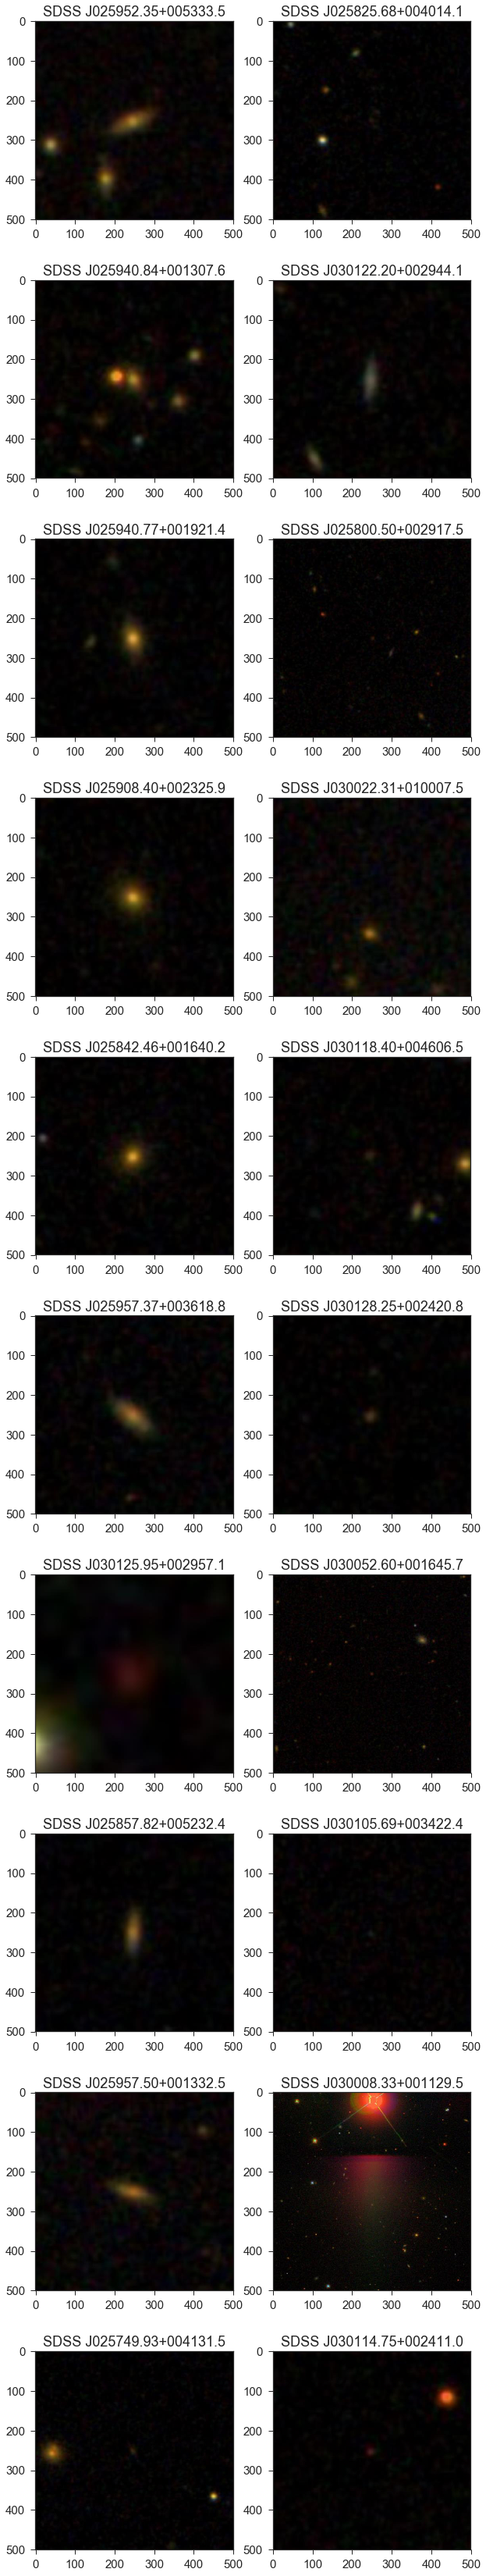

In [20]:
import skimage.io
width = 500
height = 500
pixelsize = 0.396
plt.figure(figsize=(10, 60))
subPlotNum = 1

for index,gal in crap[:20].iterrows():
    # the 'scale' parameter is set so that the image will be about 2x the size of the galaxy
    scale=80*gal['d25']/pixelsize/width
    url="http://skyservice.pha.jhu.edu/DR14/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url+="&dec="+str(gal['dec'])+"&scale="""+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
    img=skimage.io.imread(url)
    plt.subplot(10,2,subPlotNum)
    subPlotNum += 1
    plt.imshow(img)
    # show the object identifier (objId) above the image.
    plt.title(gal.galaxy.decode('utf-8'))

In [284]:
allgals = fitsio.read(parentfile, ext=1)
newclean = np.delete(allgals, crap.index)
header = [x.upper() for x in list(clean)]
fits.writeto('CleanishSample43018.fits', newclean, header, overwrite=True)

In [315]:
dat = Table.read('test.fits', format='fits')
df = dat.to_pandas()
df